In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import time
# matfile = sio.loadmat('data_mac1_cleaned_wBus2.mat')
matfile = sio.loadmat('data_mac1_full_wBus2.mat')

data = matfile['data']

print(data.dtype.names)
print(data.shape)
# format: data['variable name'] [0] [sample index] [0] [time step]
# e.g.: print(data['bus_v']     [0]     [432]      [0]   [124])

use_wandb = False
if use_wandb:
    import wandb, os
    os.environ['WANDB_NOTEBOOK_NAME'] = 'RNN_polar.ipynb'
    wandb.init(project="transient_mac1", notes="")
    wandb.run.name = 'intp10_2_400_random_start'

('bus_v', 'cur', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect', 'length', 'filename', 'bus2')
(1, 5277)


In [2]:
# Data pre-processing
np.random.seed(20200412)
n_sample = 1600
data_len = 300
data_interpolation_rate = 10
use_mac_ang_filter = True
use_Polar = True
use_cur_sum = True
if use_wandb:
    wandb.config.training_sample = n_sample
    wandb.config.data_len = data_len
    wandb.config.use_mac_ang_filter = use_mac_ang_filter
    wandb.config.use_Polar = use_Polar
    wandb.config.use_cur_sum = use_cur_sum

sample_idx = np.random.permutation(5277)

### load training data ###
if use_cur_sum:
    train_data = np.zeros((data_len*data_interpolation_rate, n_sample, 11), dtype=np.float64)
else:
    train_data = np.zeros((data_len, n_sample, 18), dtype=np.float64)
train_label_raw = np.zeros((data_len*data_interpolation_rate, n_sample, 7), dtype=np.float64)
n_entry = 0
for i in sample_idx[:4500]:
    bus_v = data['bus_v'][0][i].reshape(-1, 1)
    cur = data['cur'][0][i].reshape(-1, 1)
#     bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
    mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
    mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
    pelect = data['pelect'][0][i].reshape(-1, 1)
    pmech = data['pmech'][0][i].reshape(-1, 1)
    qelect = data['qelect'][0][i].reshape(-1, 1)
    bus2 = data['bus2'][0][i].reshape(-1, 1)
    length = qelect.shape[0]
    
    if use_mac_ang_filter and mac_ang[-1]>1000:
        print(data['filename'][0][i], 'skipped', mac_ang[-1])
        continue

#     if use_cur_sum:
#         cur = np.sum(cur, axis=1).reshape(-1, 1)

    bus_v_ang = np.unwrap(np.angle(bus_v).reshape(-1)).reshape(-1,1)
    cur_ang = np.unwrap(np.angle(cur).reshape(-1)).reshape(-1,1)
    bus2_ang = np.unwrap(np.angle(bus2).reshape(-1)).reshape(-1,1)
#     tmp_train_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
    tmp_train_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, mac_ang, mac_spd, pelect, pmech, qelect, np.abs(bus2), bus2_ang])
    clip = np.random.randint(low=0,high=48)
    tmp_train_data = tmp_train_data[clip:data_len+1+clip, :]
    
    # interpolate?
    if data_interpolation_rate:
        tmp_train_data_p = np.zeros(((tmp_train_data.shape[0]-1)*data_interpolation_rate+1, tmp_train_data.shape[1]))
        for i in range(tmp_train_data.shape[1]):
            tmp_train_data_p[:, i] = np.interp(np.arange(0.0,data_len/100+0.01/data_interpolation_rate,0.01/data_interpolation_rate), 
                                               np.arange(0.0,data_len/100+0.01,0.01), 
                                               tmp_train_data[:, i]
                                              )[:data_len*data_interpolation_rate+1]
        tmp_train_data = tmp_train_data_p
    
    
    tmp_train_label = np.delete(tmp_train_data, 0, 0)  # delete the first sample(shift the curve left)

    # delete the currents(we don't need to predict that)
    if use_cur_sum:
        tmp_train_label = np.delete(tmp_train_label, np.arange(9, 11), 1)
        tmp_train_label = np.delete(tmp_train_label, np.arange(2, 4), 1)
    else:
        tmp_train_label = np.delete(tmp_train_label, np.arange(2, 12), 1)
    tmp_train_data = np.delete(tmp_train_data, -1, 0)  # delete the last sample because there's no corresponding label

    length = tmp_train_data.shape[0]
    train_data[:, n_entry, :] = tmp_train_data
    train_label_raw[:, n_entry, :] = tmp_train_label
    n_entry += 1
    if n_entry >= n_sample:
        break
train_data = train_data[:, :n_entry, :]
train_label_raw = train_label_raw[:, :n_entry, :]
del tmp_train_data
del tmp_train_label

### load testing data ###
if use_cur_sum:
    test_data = np.zeros((data_len*data_interpolation_rate, 400, 11), dtype=np.float64)
else:
    test_data = np.zeros((data_len, 400, 18), dtype=np.float64)
test_label_raw = np.zeros((data_len*data_interpolation_rate, 400, 7), dtype=np.float64)

n_entry = 0
for i in sample_idx[4800:]:
    bus_v = data['bus_v'][0][i].reshape(-1, 1)
    cur = data['cur'][0][i].reshape(-1, 1)
#     bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
    mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
    mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
    pelect = data['pelect'][0][i].reshape(-1, 1)
    pmech = data['pmech'][0][i].reshape(-1, 1)
    qelect = data['qelect'][0][i].reshape(-1, 1)
    length = qelect.shape[0]
    bus2 = data['bus2'][0][i].reshape(-1, 1)

    if use_mac_ang_filter and mac_ang[-1]>1000:
        print(data['filename'][0][i], 'skipped', mac_ang[-1])
        continue

#     if use_cur_sum:
#         cur = np.sum(cur, axis=1).reshape(-1, 1)

    bus_v_ang = np.unwrap(np.angle(bus_v).reshape(-1)).reshape(-1,1)
    cur_ang = np.unwrap(np.angle(cur).reshape(-1)).reshape(-1,1)
    bus2_ang = np.unwrap(np.angle(bus2).reshape(-1)).reshape(-1,1)
#     tmp_test_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
    tmp_test_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, mac_ang, mac_spd, pelect, pmech, qelect, np.abs(bus2), bus2_ang])
    clip = np.random.randint(low=0,high=48)
    tmp_test_data = tmp_test_data[clip:data_len+1+clip, :]
    
    # interpolate?
    if data_interpolation_rate:
        tmp_test_data_p = np.zeros(((tmp_test_data.shape[0]-1)*data_interpolation_rate+1, tmp_test_data.shape[1]))
        for i in range(tmp_test_data.shape[1]):
            tmp_test_data_p[:, i] = np.interp(np.arange(0.0,data_len/100+0.01/data_interpolation_rate,0.01/data_interpolation_rate), 
                                              np.arange(0.0,data_len/100+0.01,0.01), 
                                              tmp_test_data[:, i]
                                             )[:data_len*data_interpolation_rate+1]
        tmp_test_data = tmp_test_data_p
    
    tmp_test_label = np.delete(tmp_test_data, 0, 0)  # delete the first sample(shift the curve left)
    if use_cur_sum:
        tmp_test_label = np.delete(tmp_test_label, np.arange(9, 11), 1)
        tmp_test_label = np.delete(tmp_test_label, np.arange(2, 4), 1)
    else:
        tmp_test_label = np.delete(tmp_test_label, np.arange(2, 12), 1)
    tmp_test_data = np.delete(tmp_test_data, -1, 0)  # delete the last sample because there's no corresponding label
    length = tmp_test_data.shape[0]
    test_data[:, n_entry, :] = tmp_test_data
    test_label_raw[:, n_entry, :] = tmp_test_label
    n_entry += 1
    if n_entry >= 400:
        break
    
test_data = test_data[:, :n_entry, :]
test_label_raw = test_label_raw[:, :n_entry, :]
del tmp_test_data
del tmp_test_label

train_data = train_data[500:1000, :, :]
test_data = test_data[500:1000, :, :]
train_label_raw = train_label_raw[500:1000, :, :]
test_label_raw = test_label_raw[500:1000, :, :]

# compute difference
# if use_cur_sum:
#     train_label = train_label_raw# - train_data[:, [0, 1, 4, 5, 6, 7, 8, 9]]
#     test_label = test_label_raw# - test_data[:, [0, 1, 4, 5, 6, 7, 8, 9]]
# else:
#     train_label = train_label_raw# - train_data[:, [0, 1, 12, 13, 14, 15, 16, 17]]
#     test_label = test_label_raw# - test_data[:, [0, 1, 12, 13, 14, 15, 16, 17]]
train_label = train_label_raw.copy()
test_label = test_label_raw.copy()

# clip angle to [-pi, pi]
# train_label[:, 1] = np.mod(train_label[:, 1]+np.pi, 2*np.pi) - np.pi
# test_label[:, 1] = np.mod(test_label[:, 1]+np.pi, 2*np.pi) - np.pi

# train_label[:, :3] = 0
# test_label[:, :3] = 0

# # normalize testing data
label_mean = np.mean(train_label.reshape(-1,7), axis=0)
label_std = np.std(train_label.reshape(-1,7), axis=0)
label_std[np.less(label_std, 1e-7)] = 1e-7
# label_mean[1] = 0  # remove normalization on angle of bus_v
# label_std[1] = 1
train_label = (train_label - label_mean) / label_std
test_label = (test_label - label_mean) / label_std

# # normalize training data
data_mean = np.mean(train_data.reshape(-1,11), axis=0)
data_std = np.std(train_data.reshape(-1,11), axis=0)
data_std[np.less(data_std, 1e-7)] = 1e-7
train_data = (train_data - data_mean) / data_std
test_data = (test_data - data_mean) / data_std

print('Train data set size:', train_data.shape)
print('Test data set size:', test_data.shape)
data_len = train_data.shape[0]

['event1836a5a39.mat'] skipped [1867.59786966]
['event1986a5a69.mat'] skipped [1867.59786969]
['event1994a5a70.mat'] skipped [1867.59810327]
['event1948a5a61.mat'] skipped [1867.59996744]
['event1809a5a33.mat'] skipped [1867.59810323]
['event1979a5a67.mat'] skipped [1867.59810322]
['event1977a5a67.mat'] skipped [1867.59843031]
['event1758a5a23.mat'] skipped [1867.59996739]
['event1671a5a6.mat'] skipped [1867.59786959]
['event2018a5a75.mat'] skipped [1867.59996745]
['event1839a5a39.mat'] skipped [1867.59810324]
['event1872a5a46.mat'] skipped [1867.59843036]
['event1980a5a67.mat'] skipped [1867.5972623]
['event1989a5a69.mat'] skipped [1867.59810326]
['event2001a5a72.mat'] skipped [1867.59786968]
['event1999a5a71.mat'] skipped [1867.59810327]
['event1840a5a39.mat'] skipped [1867.59726232]
['event1850a5a41.mat'] skipped [1867.59726237]
['event1993a5a70.mat'] skipped [1867.59996745]
['event1675a5a6.mat'] skipped [1867.59726224]
['event1674a5a6.mat'] skipped [1867.59810318]
['event1988a5a69.

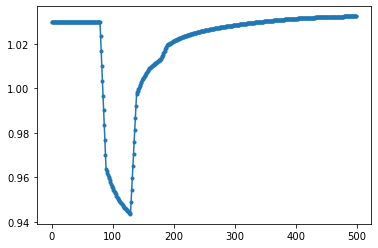

In [3]:
plt.plot(train_label_raw[:, 6, 0],'.-')
# plt.xlim([0,500])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class RNNNetwork(nn.Module):

    def __init__(self):
        super(RNNNetwork, self).__init__()
        self.hidden_dim = 400
        self.n_layers = 2
        
        if use_wandb:
            wandb.config.architecture = 'LSTM'
            wandb.config.n_layers = self.n_layers
            wandb.config.hidden_dim = self.hidden_dim

#         self.initial_hidden = torch.zeros(self.n_layers, 1, self.hidden_dim).to(device)
#         self.initial_cell = torch.zeros(self.n_layers, 1, self.hidden_dim).to(device)
#         self.initial_state = (self.initial_hidden, self.initial_cell)

#         self.initial_cell = torch.zeros(self.n_layers, 1, self.hidden_dim).to(device)

        self.lstm = nn.LSTM(input_size=11, hidden_size=self.hidden_dim, num_layers=self.n_layers)
#         self.gru = nn.GRU(input_size=10, hidden_size=self.hidden_dim, num_layers=self.n_layers)

        self.outputlayer = nn.Linear(self.hidden_dim, 7)

    def forward(self, x, states=None):
        data_len = x.size()[0]
        data_batch = x.size()[1]

        # LSTM
        (hidden_state, cell_state) = (None, None) if states is None else states
        if hidden_state is None:
            hidden_state = torch.zeros(self.n_layers, data_batch, self.hidden_dim).to(device)
        if cell_state is None:
            cell_state = torch.zeros(self.n_layers, data_batch, self.hidden_dim).to(device)

        rnn_out, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state))
        states = (hidden_state, cell_state)

        # GRU
#         if states is None:
#             states = torch.zeros(self.n_layers, data_batch, self.hidden_dim).to(device)
#         rnn_out, states = self.gru(x, states)

        pred = self.outputlayer(rnn_out.view(-1, self.hidden_dim))
        return pred.view(data_len, data_batch, 7), states

    def initial_states(self):
        return None


def weights_init(m):
    if isinstance(m, nn.Linear):
        #         torch.nn.init.kaiming_normal_(m.weight)
        #         torch.nn.init.normal_(m.weight, mean=0, std=0.001)
        torch.nn.init.normal_(m.bias, mean=0, std=0.001)
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(m.bias, mode='fan_in', nonlinearity='relu')

    if isinstance(m, nn.BatchNorm1d):
        torch.nn.init.zeros_(m.bias)
        torch.nn.init.ones_(m.weight)


torch.manual_seed(20200410)
if torch.cuda.is_available():
    print('GPU is available. Will be applied.')
    use_GPU = True
    device = torch.device('cuda')

    torch.cuda.empty_cache()
    torch.cuda.manual_seed(20200410)
    torch.cuda.manual_seed_all(20200410)
    torch.backends.cudnn.deterministic = True
else:
    print('GPU is NOT available. CPU will be applied.')
    use_GPU = False
    device = torch.device('cpu')

model = RNNNetwork().float()
model.apply(weights_init)
model = model.to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')


batchsize = 160
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01*2, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters(), lr=0.0001)


train_data_torch = torch.from_numpy(train_data).float()
train_label_torch = torch.from_numpy(train_label).float()
test_data_torch = torch.from_numpy(test_data).float()
test_label_torch = torch.from_numpy(test_label).float()


def test(data_torch, label_torch):
    loss = None
    prediction = None
    model.eval()
    test_batchsize = 400
    with torch.no_grad():
        for j in range(0, data_torch.shape[1], test_batchsize):
            inputs_torch = data_torch[:, j:j+test_batchsize, :]
            labels_torch = label_torch[:, j:j+test_batchsize, :]

            inputs_torch = inputs_torch.to(device)
            labels_torch = labels_torch.to(device)

            # forward
            pred_torch, _ = model(inputs_torch)
            loss_torch = criterion(pred_torch, labels_torch)

            if use_GPU:
                pred_torch = pred_torch.cpu()
            pred = pred_torch.data.numpy()

            loss = np.array([loss_torch.item()]) if loss is None else np.hstack([loss, loss_torch.item()])
            prediction = pred if prediction is None else np.concatenate([prediction, pred], axis=1)
    return loss.mean(), prediction

def evaluation(eval_data_torch, eval_label_raw):
    t_max = data_len
    samples = eval_data_torch.shape[1]
    eval_batchsize = 400
    rse = np.zeros((samples,7))

    model.eval()
    with torch.no_grad():
        for i in range(0,samples,eval_batchsize):
            rnn_states = model.initial_states()
            output_data = np.zeros((t_max, eval_batchsize, 7))
            input_data_torch = eval_data_torch[0, i:i+eval_batchsize, :].reshape(1,eval_batchsize,-1).to(device)

            for t in range(0, t_max):
                output_data_torch, rnn_states = model(input_data_torch, rnn_states)
                output_data[t,:] = output_data_torch.data.cpu().numpy()
                if t<t_max-1:
                    input_data_torch = torch.cat((output_data_torch[0,:,0:2], eval_data_torch[t+1,i:i+eval_batchsize,2:4].to(device), output_data_torch[0,:,2:7], eval_data_torch[t+1,i:i+eval_batchsize,9:11].to(device)), dim=1).reshape(1,eval_batchsize,-1)

            output_data = output_data * label_std + label_mean

            for b in range(eval_batchsize):
                for q in range(7):
                    if q == 5:
                        # skip pmech, which is a constant
                        continue
                    truth_curve = eval_label_raw[:t_max, i+b, q]
                    pred_curve = output_data[:t_max, b, q]
                    rse[i+b,q] = np.linalg.norm(truth_curve - pred_curve, 2)/ (np.linalg.norm(truth_curve-truth_curve.mean(), 2) + 1e-6)
    return rse

# checkpoint = torch.load('saved_models/5cuxeqxt/500.pt')
checkpoint = torch.load('wandb/run-20200710_014134-1000ojrp/model.pt')
if 'checkpoint' in locals():
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    

rse_train = evaluation(train_data_torch, train_label_raw)
rse_test = evaluation(test_data_torch, test_label_raw)
print('Before training: train eval rse = %.3e, test eval rse = %.3e' % (np.median(rse_train,axis=0).mean(), np.median(rse_test,axis=0).mean()))
    
trained_epochs = 1
loss_curve = []

GPU is available. Will be applied.
The model has 1,946,807 trainable parameters
Before training: train eval rse = 1.846e-02, test eval rse = 1.936e-02


Training process took 0.0 mins.
GPU memory stats: Max Cached 94 Mb, Max Reserved 94 Mb, Max Allocated 83 Mb
Denormalized: train Loss = 6.406e-05, test Loss = 6.302e-05
Relative SE after de-normalization: train 1.908e-02, test 2.003e-02
[0.01650551 0.01297795 0.02259355 0.02857586 0.03084387 0.
 0.02399844]
Overall: 0.019356453959059224


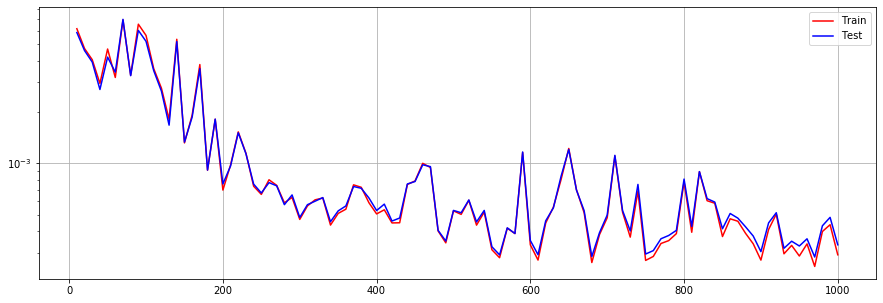

In [5]:
#### %matplotlib inline
start_time = time.time()
teacher_forcing_ratio_decay = True
teacher_forcing_ratio = 0.75
train_for_epochs = 0
if use_wandb:
    wandb.config.teacher_forcing = teacher_forcing_ratio
    wandb.config.teacher_forcing_ratio_decay = teacher_forcing_ratio_decay

if 'checkpoint' in locals():
    # to compatible with random seed
    for i in range(trained_epochs, trained_epochs+checkpoint['epoch']):
        if teacher_forcing_ratio_decay:
            teacher_forcing_ratio *= 0.9975 #  0.9966
        for j in range(0, n_sample, batchsize):
            use_teacher_forcing = np.random.random()<teacher_forcing_ratio
    trained_epochs = trained_epochs+checkpoint['epoch']
    loss_curve = checkpoint['loss_curve']

    if use_wandb:
        loss, _ = test(train_data_torch, train_label_torch)
        loss_test, _ = test(test_data_torch, test_label_torch)
        rse = evaluation(test_data_torch, test_label_raw)
        wandb.log({"Epoch": i, "Train Loss": loss, "Test Loss": loss_test, 'Eval RSE':np.median(rse,axis=0).mean()})


for i in range(trained_epochs, trained_epochs+train_for_epochs):    
    model.train()
    if teacher_forcing_ratio_decay:
        teacher_forcing_ratio *= 0.9975 #  0.9966

    for j in range(0, n_sample, batchsize):
        loss_r = np.zeros((data_len))
#         input_batch = train_data_torch[:data_len, j:j+batchsize, :].reshape(data_len,batchsize,-1).to(device)
#         outputs = torch.zeros((data_len,batchsize,8), dtype=torch.float32, device=device)
        rnn_states = model.initial_states()

        loss = 0

        use_teacher_forcing = np.random.random()<teacher_forcing_ratio
        if use_teacher_forcing:
#             with total teacher forcing, 20x faster
            inputs = train_data_torch[:data_len, j:j+batchsize, :].reshape(data_len,batchsize,-1).to(device)
            outputs, rnn_states = model(inputs, rnn_states)
            labels = train_label_torch[:, j:j+batchsize, :].to(device)
            loss = criterion(outputs, labels)
        else:
            for t in range(data_len):
                inputs = train_data_torch[t, j:j+batchsize, :].reshape(1,batchsize,-1).clone().to(device)
                if t>0:
                    # teacher forcing: replacing inputs with ground truth
                    inputs[:,:,[0,1,4,5,6,7,8]] = outputs[0,:,:].detach()

                # forward
                outputs, rnn_states = model(inputs, rnn_states)

                labels = train_label_torch[t, j:j+batchsize, :].reshape(1,batchsize,-1).to(device)
                loss += criterion(outputs, labels)
                loss_r[t] = criterion(outputs, labels).cpu().data.numpy()
            loss /= data_len
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient clip
#         torch.nn.utils.clip_grad_value_(model.parameters(), 0.002)
#         torch.nn.utils.clip_grad_value_(model.parameters(), 0.0005)
        torch.nn.utils.clip_grad_value_(model.parameters(), 0.0001)

        optimizer.step()
        
    if i % 10 == 0:
        loss, _ = test(train_data_torch, train_label_torch)
        loss_test, _ = test(test_data_torch, test_label_torch)
#         rse = evaluation(train_data_torch, train_label_torch)

        rse_train = evaluation(train_data_torch, train_label_raw)
        rse_test = evaluation(test_data_torch, test_label_raw)
#         rse = evaluation(test_data_torch, test_label_raw)

        loss_curve.append([i, loss, loss_test])
        if use_wandb:
            wandb.log({"Epoch": i, "Train Loss": loss, "Test Loss": loss_test, 'Eval RSE in training':np.median(rse_train,axis=0).mean(), 'Eval RSE':np.median(rse_test,axis=0).mean()})


    if i % 10 == 0:
        ETA = (time.time() - start_time) / (i - trained_epochs + 1) * (trained_epochs+train_for_epochs-i) / 60
        print(time.strftime('%H:%M:%S  ', time.localtime(time.time())), end="")
        print('ETA:{:.1f}mins '.format(ETA), end="")
        print('Epoch {}: train Loss = {:.3e}, test Loss = {:.3e}, eval = {:.3e}'.format(i, loss, loss_test, np.median(rse_test,axis=0).mean()))
        
    if use_wandb and i % 100 == 0:
        if not os.path.exists('saved_models/{:s}/'.format(wandb.run.id)):
            os.makedirs('saved_models/{:s}/'.format(wandb.run.id))
        torch.save({'model_state_dict':model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': i, 'loss_curve':loss_curve}, 'saved_models/{:s}/{:d}.pt'.format(wandb.run.id, i))



trained_epochs = trained_epochs+train_for_epochs
print('Training process took {:.1f} mins.'.format((time.time()-start_time)/60))

if len(loss_curve) > 0:
    plt.figure(0, figsize=(15, 5))
    plt.plot(np.array(loss_curve)[:, 0], np.array(loss_curve)[:, 1], 'r', label="Train")
    plt.plot(np.array(loss_curve)[:, 0], np.array(loss_curve)[:, 2], 'b', label="Test")
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
#     plt.show()

print('GPU memory stats: Max Cached {:.0f} Mb, Max Reserved {:.0f} Mb, Max Allocated {:.0f} Mb'.format(
    torch.cuda.max_memory_cached(0)/1024/1024, torch.cuda.max_memory_reserved(0)/1024/1024, torch.cuda.max_memory_allocated(0)/1024/1024))

_, prediction_train_raw = test(train_data_torch, train_label_torch)
_, prediction_test_raw = test(test_data_torch, test_label_torch)

if use_cur_sum:
    prediction_train = prediction_train_raw * label_std + label_mean
    prediction_test = prediction_test_raw * label_std + label_mean
else:
    prediction_train = prediction_train_raw * label_std + label_mean
    prediction_test = prediction_test_raw * label_std + label_mean
    
mse_train = np.mean(np.mean(np.square(prediction_train - train_label_raw), axis=1), axis=0)
mse_test = np.mean(np.mean(np.square(prediction_test - test_label_raw), axis=1), axis=0)

print('Denormalized: train Loss = %.3e, test Loss = %.3e' % (mse_train.mean(), mse_test.mean()))

se_train = np.linalg.norm(prediction_train - train_label_raw, 2, axis=0) / (np.linalg.norm(train_label_raw-train_label_raw.mean(axis=0), 2, axis=0) + 1e-5)
se_test = np.linalg.norm(prediction_test - test_label_raw, 2, axis=0) / (np.linalg.norm(test_label_raw-test_label_raw.mean(axis=0), 2, axis=0) + 1e-5)
rse_train = np.median(se_train, axis=0)
rse_test = np.median(se_test, axis=0)
print('Relative SE after de-normalization: train {:.3e}, test {:.3e}'.format(rse_train.mean(), rse_test.mean()))

### Evaluation
rse = evaluation(test_data_torch, test_label_raw)
print(np.median(rse,axis=0))
print('Overall:', np.median(rse,axis=0).mean())
    
if use_wandb:
    wandb.log({"Training Time": (time.time()-start_time)/60})
    wandb.log({"Train Relative SE": rse_train.mean()})
    wandb.log({"Test Relative SE": rse_test.mean()})
    wandb.log({"Detailed Relative SE": rse_train})
    wandb.log({"Detailed Relative SE": rse_test})
    
    wandb.log({"Prediction RSE": np.median(rse,axis=0)})
    wandb.log({"Overall": np.median(rse,axis=0).mean()})

In [6]:
# torch.save(model.state_dict(), 'GRU_CL0.75.pt')

# Save model to wandb
if use_wandb:
    import os
    torch.save({'model_state_dict':model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch': i, 'loss_curve':loss_curve}, os.path.join(wandb.run.dir, 'model.pt'))
#     torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model.pt'))

Text(0.5, 1.0, 'Relative SE on different components')

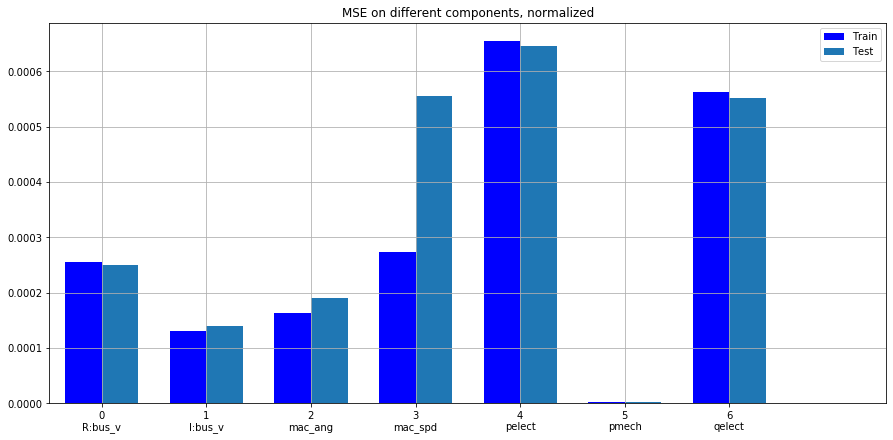

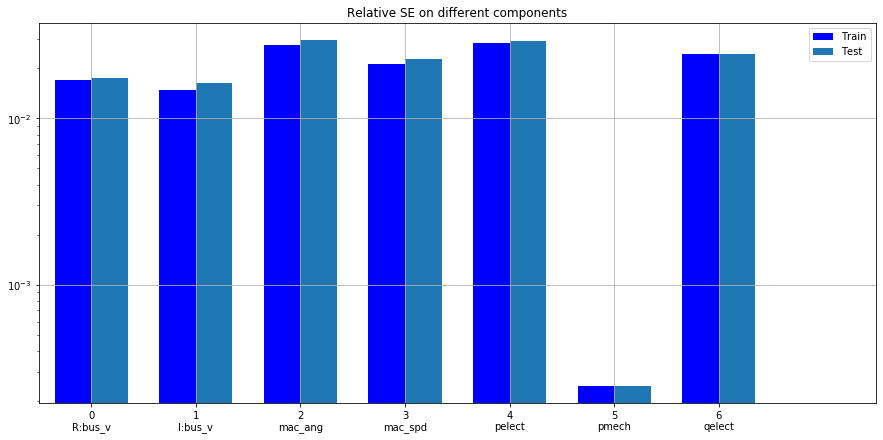

In [7]:
c = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'orange', 'b', 'b', 'b']
c2 = ['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'darkorange', 'C0', 'C0', 'C0']
x = np.arange(7)
# xticks=('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect')
xticks = ('0\nR:bus_v', '1\nI:bus_v', '2\nmac_ang', '3\nmac_spd', '4\npelect', '5\npmech', '6\nqelect')
width = 0.35

# plt.figure(1,figsize=(15,7))
# plt.bar(range(8), data_std, color=c)
# plt.xticks(range(8), ('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect'))
# plt.grid(True)
# plt.xlim([-0.5,17.5])
# # plt.ylim([0,0.001])
# plt.title('Standard Deviations on different components')

mse_train_n = np.mean(np.mean(np.square(prediction_train_raw - train_label), axis=1), axis=0)
mse_test_n = np.mean(np.mean(np.square(prediction_test_raw - test_label), axis=1), axis=0)

plt.figure(2, figsize=(15, 7))
plt.bar(x-width/2, mse_train_n, width, label='Train', color=c)
plt.bar(x+width/2, mse_test_n, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
# plt.ylim([0,1e-6])
plt.title('MSE on different components, normalized')


plt.figure(3, figsize=(15, 7))
plt.bar(x-width/2, rse_train, width, label='Train', color=c)
plt.bar(x+width/2, rse_test, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
plt.yscale('log')
# plt.ylim([0,1e-1])
plt.title('Relative SE on different components')
# plt.show()

No Cheating.


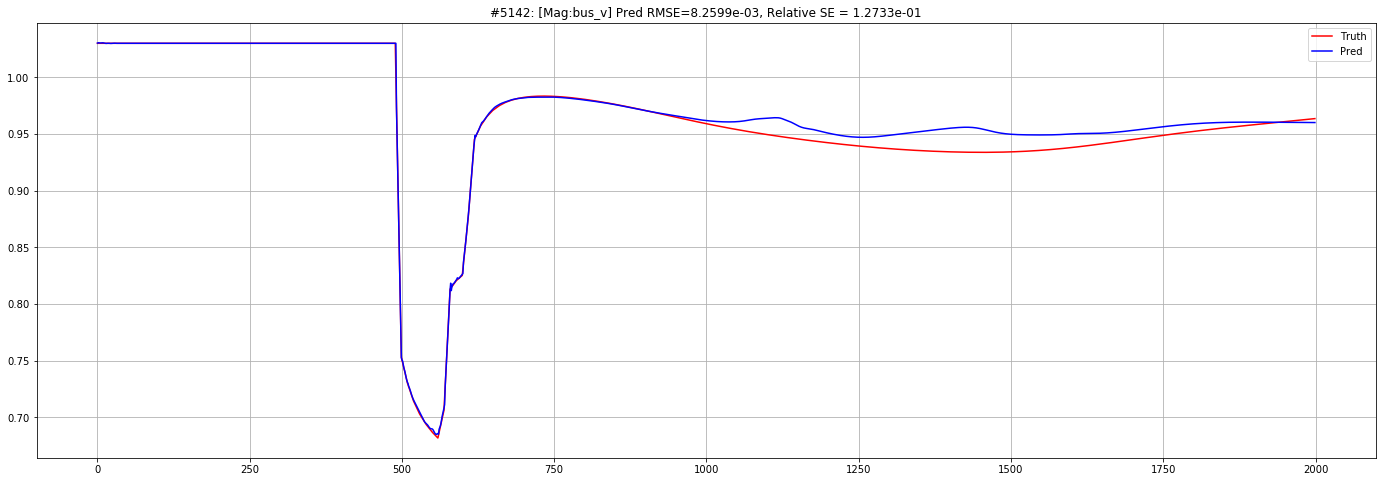

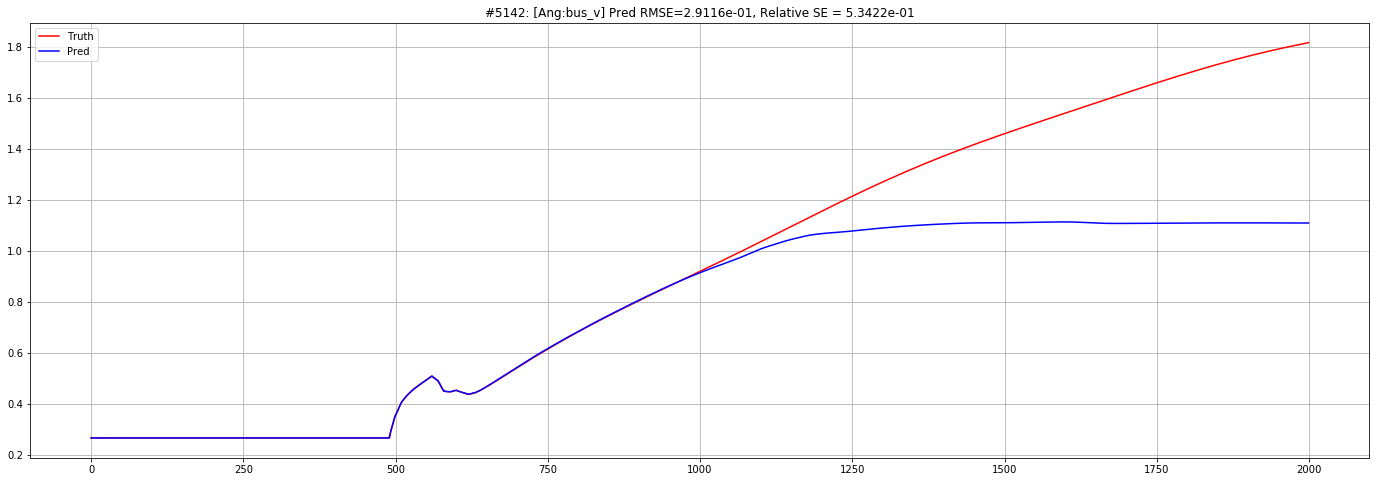

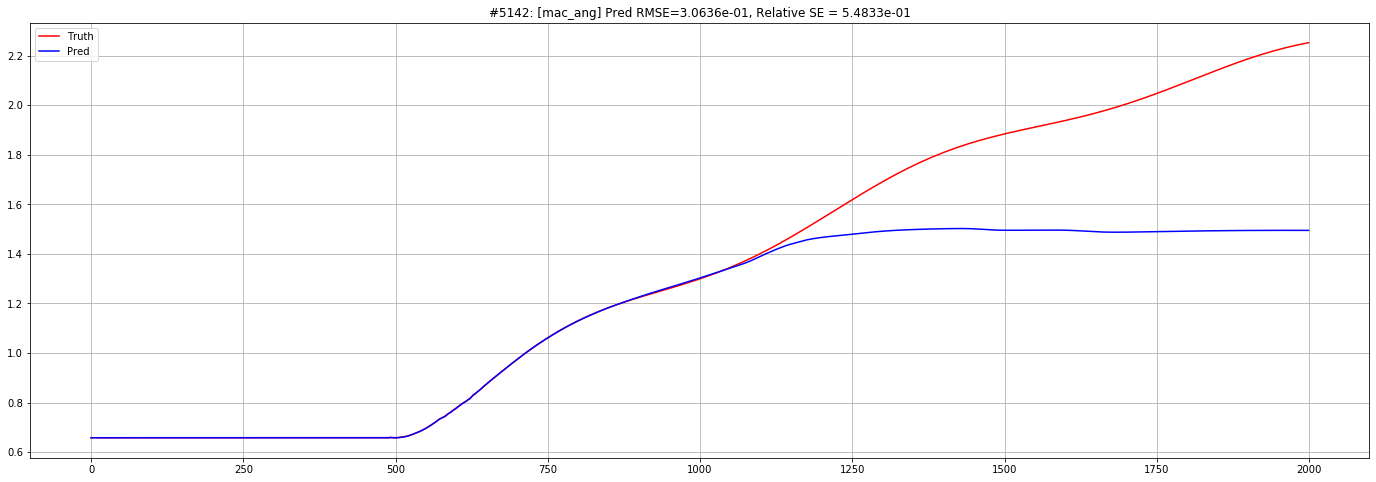

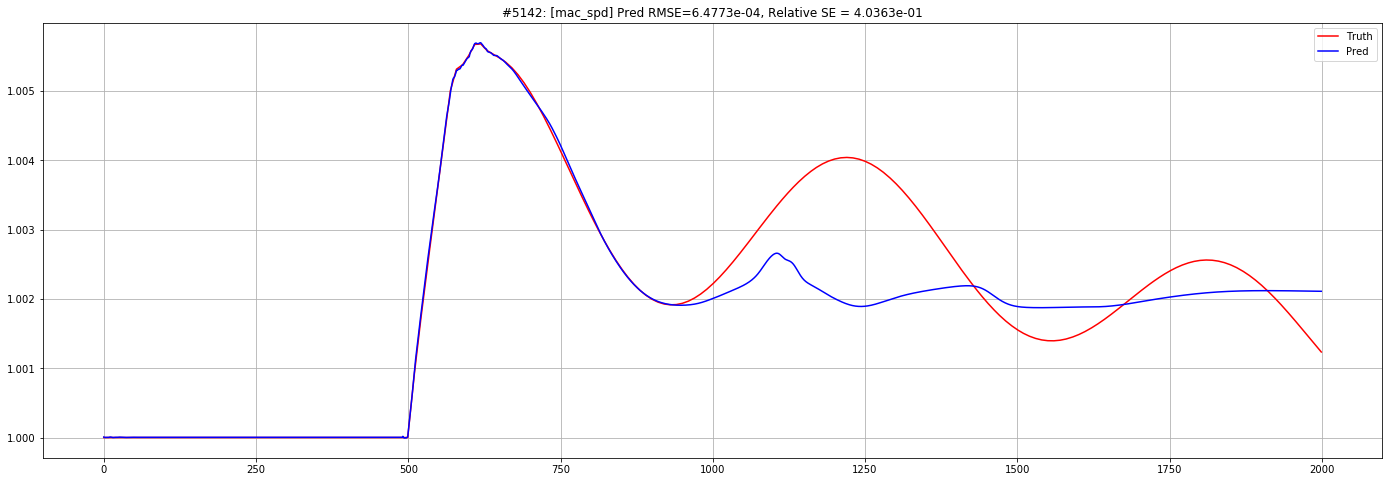

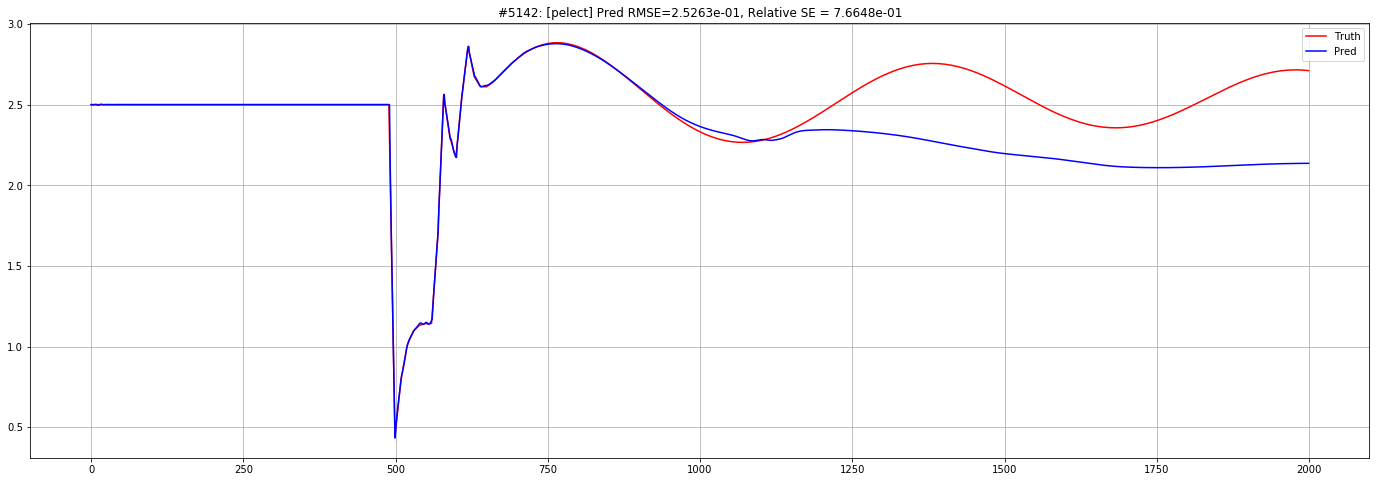

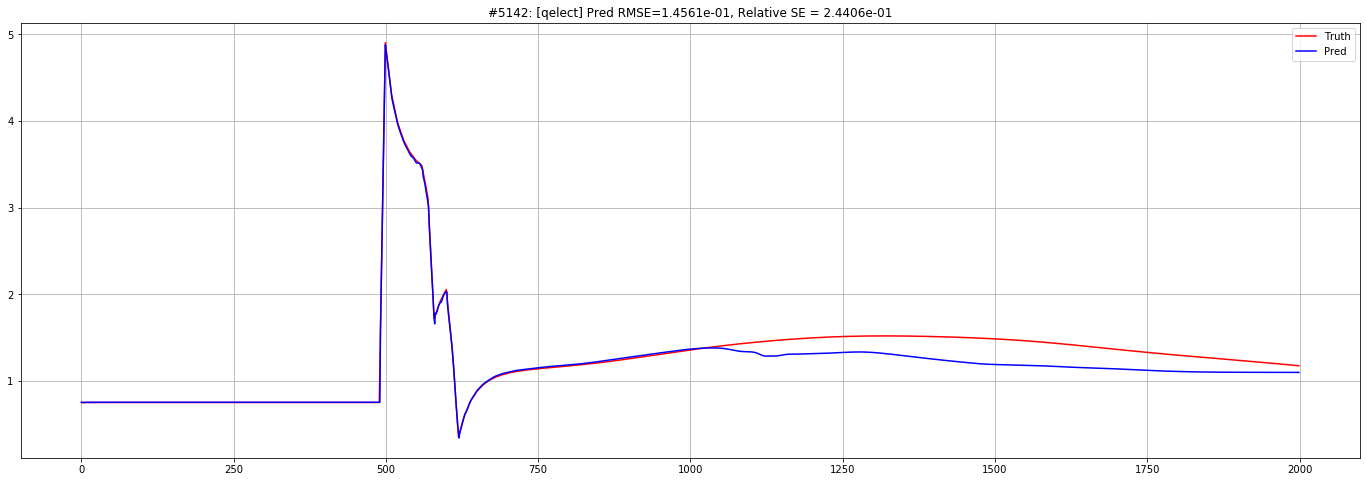

In [14]:
replace_mode = 0 # 0:no cheating  1: replace accord to the list  2: replace all others  3: replace all, including the plotting one
# entry = np.floor(np.random.uniform(low=0, high=1600, size=(1, 1))).astype(int).reshape(-1)
# entry = np.floor(np.random.uniform(low=4800, high=5200, size=(1, 1))).astype(int).reshape(-1)

entry=[5142]
# entry =[2108]  % contigency at Line 5
# entry=[4880]  % another contigency at Line 5
# entry = sample_idx[entry]
t_max = 2000
if use_cur_sum:
    quantities = [0,1,4,5,6,7,8]  # in data indices
    quantities_transform = [0, 1, -1, -1, 2, 3, 4, 5, 6]  # transform data indices to label indices
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur_sum', 'A:cur_sum', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']
    quantities_replace = [0,1]  # replace these in data indices
#     quantities_replace = [0,1,4,5,6,7,8,9]  # replace these in data indices
else:
    quantities = [0,1,12,13,14,15,16,17]
    quantities_transform = [0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 3, 4, 5, 6, 7]
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur1', 'M:cur2', 'M:cur3', 'M:cur4', 'M:cur5', 'A:cur1', 'A:cur2', 'A:cur3', 'A:cur4', 'A:cur5', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']
    quantities_replace = [0,1,12,13,15,16,17]
    
if replace_mode == 0:
    print('No Cheating.')
elif replace_mode == 1:
    print('Replacing quantites:')
    for q in quantities_replace:
        print('    [{:d}]'.format(q),quantites_names[q])
    print('Keeping quantites:')
    for q in quantities:
        if not (q in quantities_replace):
            print('    [{:d}]'.format(q),quantites_names[q])
    print()
elif replace_mode == 2:
       print('Replacing all other quantities except the plotting one.')
elif replace_mode == 3:
       print('Replacing all quantities.')

model.eval()
for i in entry:    
    bus_v = data['bus_v'][0][i].reshape(-1, 1)
    cur = data['cur'][0][i].reshape(-1, 1)
#     bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
    mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
    mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
    pelect = data['pelect'][0][i].reshape(-1, 1)
    pmech = data['pmech'][0][i].reshape(-1, 1)
    qelect = data['qelect'][0][i].reshape(-1, 1)
    bus2 = data['bus2'][0][i].reshape(-1, 1)



    if use_mac_ang_filter and mac_ang[-1]>1000:
        print('Not valid:', data['filename'][0][i], mac_ang[-1])
        continue

#     if use_cur_sum:
#         cur = np.sum(cur, axis=1).reshape(-1, 1)
        
    bus_v_ang = np.unwrap(np.angle(bus_v).reshape(-1)).reshape(-1,1)
    cur_ang = np.unwrap(np.angle(cur).reshape(-1)).reshape(-1,1)
    bus2_ang = np.unwrap(np.angle(bus2).reshape(-1)).reshape(-1,1)
    tmp_test_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, mac_ang, mac_spd, pelect, pmech, qelect, np.abs(bus2), bus2_ang])
#     tmp_test_data = np.array(tmp_test_data, dtype=np.float32)
    clip = 0
    tmp_test_data = tmp_test_data[clip:301+clip, :]
    
    # interpolate?
    if data_interpolation_rate:
        tmp_test_data_p = np.zeros(((tmp_test_data.shape[0]-1)*data_interpolation_rate+1, tmp_test_data.shape[1]))
        for j in range(tmp_test_data.shape[1]):
            tmp_test_data_p[:, j] = np.interp(np.arange(0.0,300/100+0.01/data_interpolation_rate,0.01/data_interpolation_rate), 
                                              np.arange(0.0,300/100+0.01,0.01), 
                                              tmp_test_data[:, j]
                                             )[:data_len*data_interpolation_rate+1]
        tmp_test_data = tmp_test_data_p
    
    tmp_test_label = np.delete(tmp_test_data, 0, 0)  # delete the first sample(shift the curve left)
    if use_cur_sum:
        tmp_test_label = np.delete(tmp_test_label, np.arange(9, 11), 1)
        tmp_test_label = np.delete(tmp_test_label, np.arange(2, 4), 1)
    else:
        tmp_test_label = np.delete(tmp_test_label, np.arange(2, 12), 1)
    tmp_test_data = np.delete(tmp_test_data, -1, 0)
    
    tmp_test_data = tmp_test_data[500:500+t_max, :]
    tmp_test_label = tmp_test_label[500:500+t_max, :]
    
    tmp_test_data = (tmp_test_data - data_mean) / data_std
    tmp_test_data = torch.from_numpy(tmp_test_data).to(device).float()

    for q in range(9):
        if quantites_names[q] == 'pmech':
            continue
        if not (q in quantities):
#             plt.figure(q, figsize=(12, 8))
#             if q==2:
#                 plt.plot(range(t_max-1), np.abs(cur)[1:t_max], 'r')
#             if q==3:
#                 plt.plot(range(t_max-1), cur_ang[1:t_max], 'r')
#             plt.grid(True)
#             plt.title('#{:d}: [{:s}]'.format(i, quantites_names[q]))
            continue
#         if q in quantities_replace:
#             continue


        for t_start in [0]:
            input_data_torch = tmp_test_data[t_start, :].reshape(1,1,-1)
            rnn_states = model.initial_states()
            output_data = np.zeros_like(tmp_test_label)
            for t in range(t_start, t_max):
                output_data_torch, rnn_states = model(input_data_torch, rnn_states)
                output_data[t,:] = output_data_torch.data.cpu().numpy()
#                 if t == t_start or t == t_start+1 or t == t_start+2:
#                     for nn in input_data_torch.data.cpu().numpy()[0,0,:]:
#                         print('{:.3f} '.format(nn),end='')
#                     print()
#                     print(quantites_names[q], t, input_data_torch[0,0,q].item(), output_data[t,quantities_transform[q]])
                if t < t_max-1:
                    input_data_torch = torch.cat((output_data_torch[0,0,0:2], tmp_test_data[t+1,2:4], output_data_torch[0,0,2:7], tmp_test_data[t+1,9:11])).reshape(1,1,-1)

#                 for r in quantities:
#                     if ((replace_mode == 1) and (r in quantities_replace)) or ((replace_mode == 2) and (r != q)) or (replace_mode == 3):
#                         input_data_torch[0,0,r] = tmp_test_data[t+1, r]

            output_data = output_data * label_std + label_mean

            truth_curve = tmp_test_label[:t_max, quantities_transform[q]]
            pred_curve = output_data[:t_max, quantities_transform[q]]
            
            plt.figure(q, figsize=(24, 8))
            
            if t_start == 0:
                plt.plot(range(t_max), truth_curve, 'r', label='Truth')
                plt.plot(range(t_max), pred_curve, 'b', label='Pred')
                plt.legend()
                plt.grid(True)

                rmse = np.sqrt(np.mean(np.square(truth_curve - pred_curve)))
                rse = np.linalg.norm(truth_curve - pred_curve, 2)/ np.linalg.norm(truth_curve-truth_curve.mean(), 2)
                plt.title('#{:d}: [{:s}] Pred RMSE={:.4e}, Relative SE = {:.4e}'.format(i, quantites_names[q], rmse, rse))
            else:
                plt.plot(range(t_start, t_max), pred_curve[t_start:],'y')
#             plt.plot([47,47], [pred_curve.min(), pred_curve.max()],'k--')
#             plt.xlim([0,200])

# plt.show()

# sio.savemat('example1.mat',{'label':tmp_test_label, 'data':output_data})